In [9]:
import tensorflow as tf
import os
from src.utils import reload_model_from_epoch
from src.modeling.preprocess import load, resize, load_image_and_sketch
from src.preprocessing import find_sketch_threshold
from src.visualize import configure_axislabels_and_title, configure_ticklabels_and_params, configure_legend
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
from tensorflow.io import read_file, decode_jpeg
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
import src.model_analysis.generation as generation
import src.model_analysis.logs as logs
import src.model_analysis.fid as fid
from tensorflow.keras.utils import plot_model

In [10]:
base_path = '..'

In [11]:
generator = reload_model_from_epoch(f'{base_path}/models/pix2pix/epoch_010', 'pix2pix', base_path)[0]

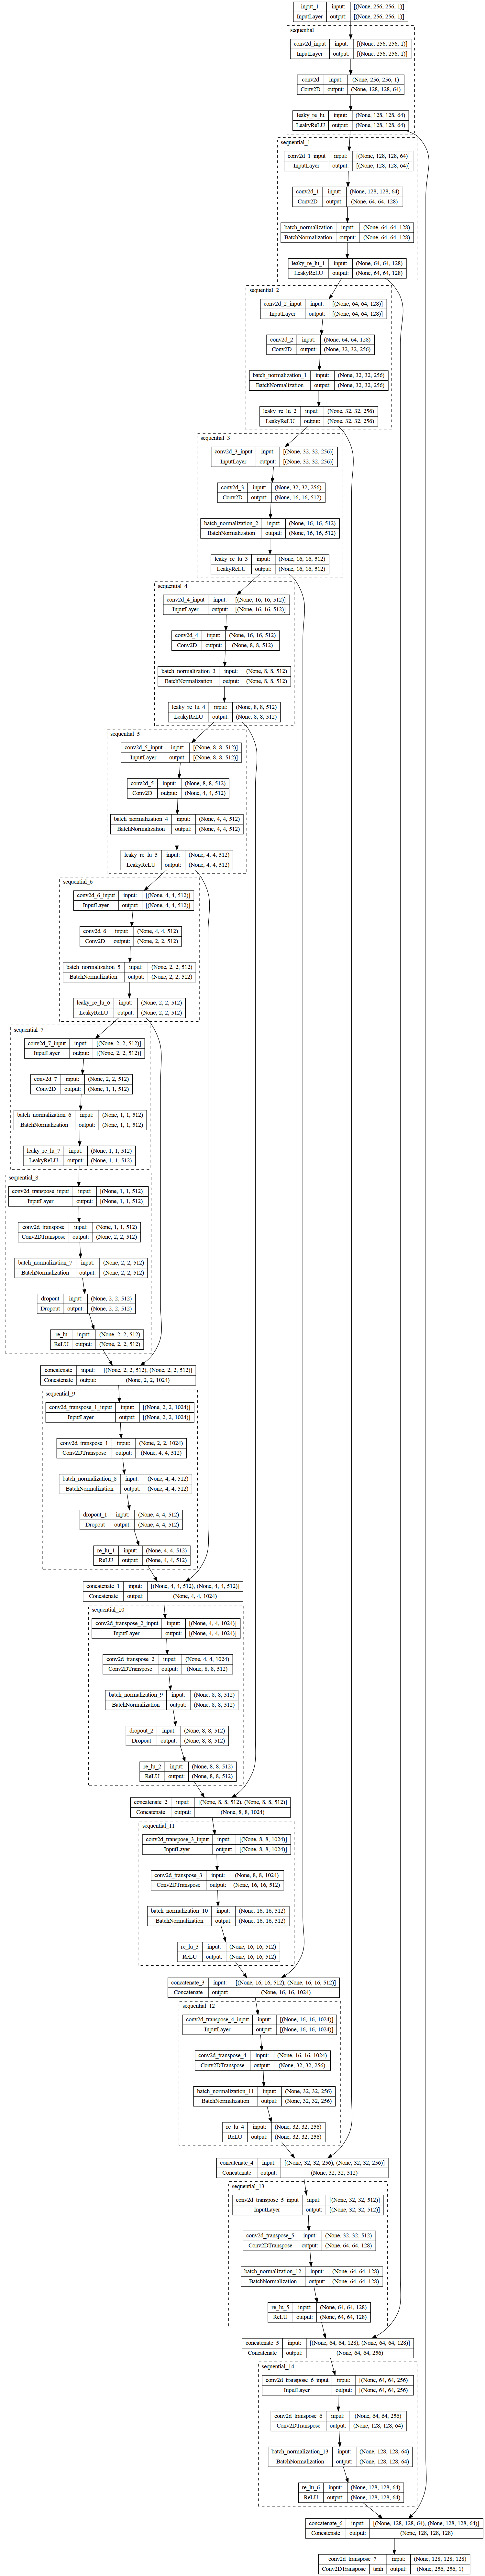

In [12]:
plot_model(generator, show_shapes = True, expand_nested = True, show_layer_activations = True)

In [ ]:
datasets = ['train', 'test']
models = ['pix2pix', 'autopainter']
epochs = np.arange(10, 210, 10)

for dataset in datasets:
    print(f'Generating images from {dataset}.')
    data = os.listdir(f'{base_path}/data/{dataset}')
    for model in models:
        print(f'Generating images using {model}.')
        for epoch in epochs:
            print(f'Generating images using epoch {epoch}.')
            epoch_dir = f'{base_path}/models/{model}/epoch_{epoch:03d}'
            generator = reload_model_from_epoch(epoch_dir, model, base_path)[0]
            
            for image in data:
                print(f'Generating image for {image}.')
                end_dir = f'{base_path}/data/generated/{dataset}/{model}/epoch_{epoch}'
                image_path = f'{base_path}/data/{dataset}/{image}'
                generation.generate_and_save_image(image_path, generator, end_dir, epoch, model)

In [ ]:
log_file = '../logs/pix2pix/epoch_data.csv'
columns = ['epoch', 'gen_total_loss', 'gen_gan_loss', 'gen_l1_loss', 'disc_loss']
pix2pix_df = logs.parse_logs(log_file, columns, scale = True, plot = True)

In [ ]:
log_file = '../logs/autopainter/epoch_data.csv'
columns = ['epoch', 'gen_total_loss', 'gen_gan_loss', 'gen_l1_loss', 'gen_tv_loss', 'gen_f_loss', 'disc_loss']
autopainter_df = logs.parse_logs(log_file, columns, scale = True, plot = True)

In [ ]:
fig = logs.plot_gen_and_disc_losses(pix2pix_df, 'pix2pix')
plt.savefig('../visualizations/model_health/pix2pix_losses.png', format = 'png', bbox_inches = 'tight')
plt.show()

In [ ]:
fig = logs.plot_gen_and_disc_losses(autopainter_df, 'Autopainter')
plt.savefig('../visualizations/model_health/autopainter_losses.png', format = 'png', bbox_inches = 'tight')
plt.show()

In [ ]:
epochs = np.arange(10, 210, 10)
models = ['pix2pix', 'autopainter']

train_images = tf.data.Dataset.list_files(f'{base_path}/data/train/*.jpg')
train_images = train_images.map(load, num_parallel_calls = tf.data.AUTOTUNE)
train_images = train_images.map(lambda x, y: x, num_parallel_calls = tf.data.AUTOTUNE)
train_images = train_images.map(fid.preprocess_for_inception, num_parallel_calls = tf.data.AUTOTUNE)
train_images = train_images.batch(1)

for model in models:
    print(f'Using model {model}.')
    for epoch in epochs:
        print(f'Using epoch {epoch}.')
        generated_image_dir = f'{base_path}/data/generated/train/{model}/epoch_{epoch:03d}/*.jpg'
        
        print('Creating generated dataset.')
        train_generated = fid.create_inception_generated_dataset(generated_image_dir)
        
        print('Getting inception embeddings for real images.')
        real_image_embeddings = fid.compute_embeddings(train_images, 10000)
        
        print('Getting inception embeddings for generated images.')
        generated_image_embeddings = fid.compute_embeddings(train_generated, 10000)
        
        print('Calculating FID.')
        fid = fid.calculate_fid(real_image_embeddings, generated_image_embeddings)
        
        log_location = f'{base_path}/logs/{model}/fid_scores.csv'
        print(f'Writing to {log_location}.')
        with open(log_location, 'a') as f:
            f.write(f'Epoch: {epoch:03d}, FID: {fid:.03f}')

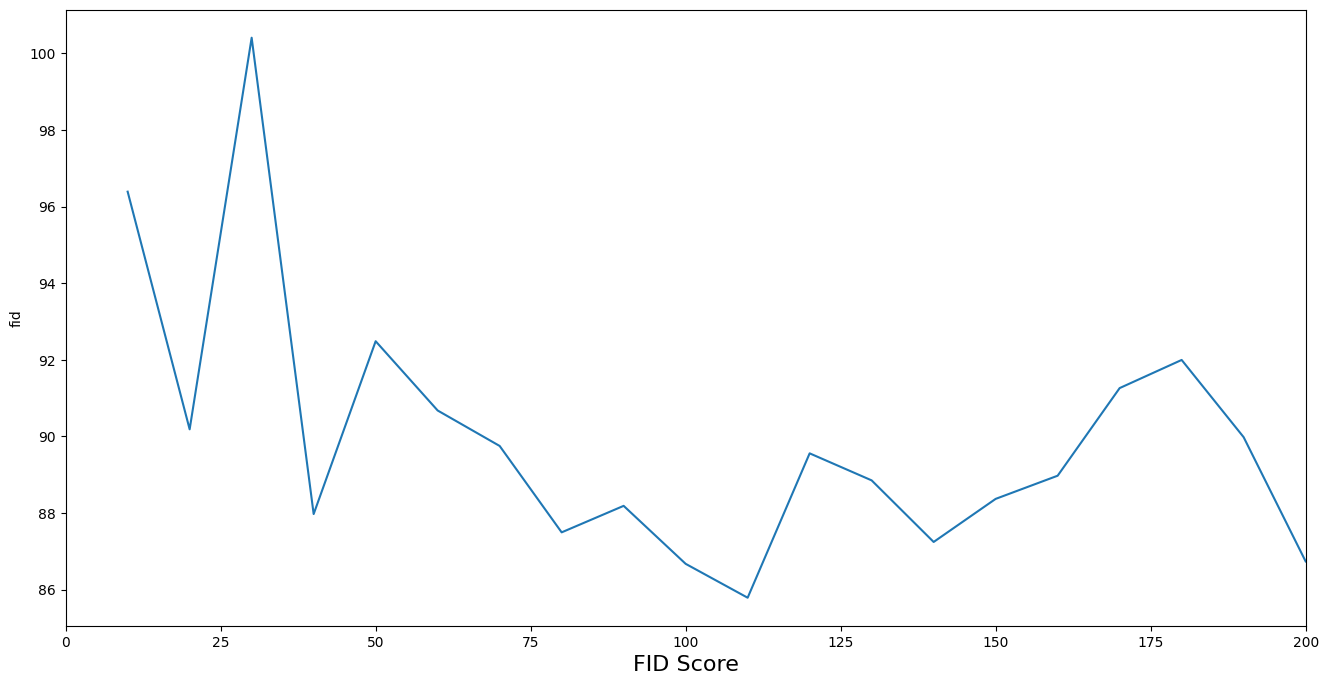

In [3]:
fid_file = '../logs/pix2pix/fid_scores.csv'
pix2pix_fid = fid.parse_fid(fid_file, plot = True)

In [4]:
pix2pix_fid.sort_values('fid')

,epoch,fid
9,110,85.788
10,100,86.673
0,200,86.736
6,140,87.244
12,80,87.495
16,40,87.973
11,90,88.187
5,150,88.369
7,130,88.852
4,160,88.974


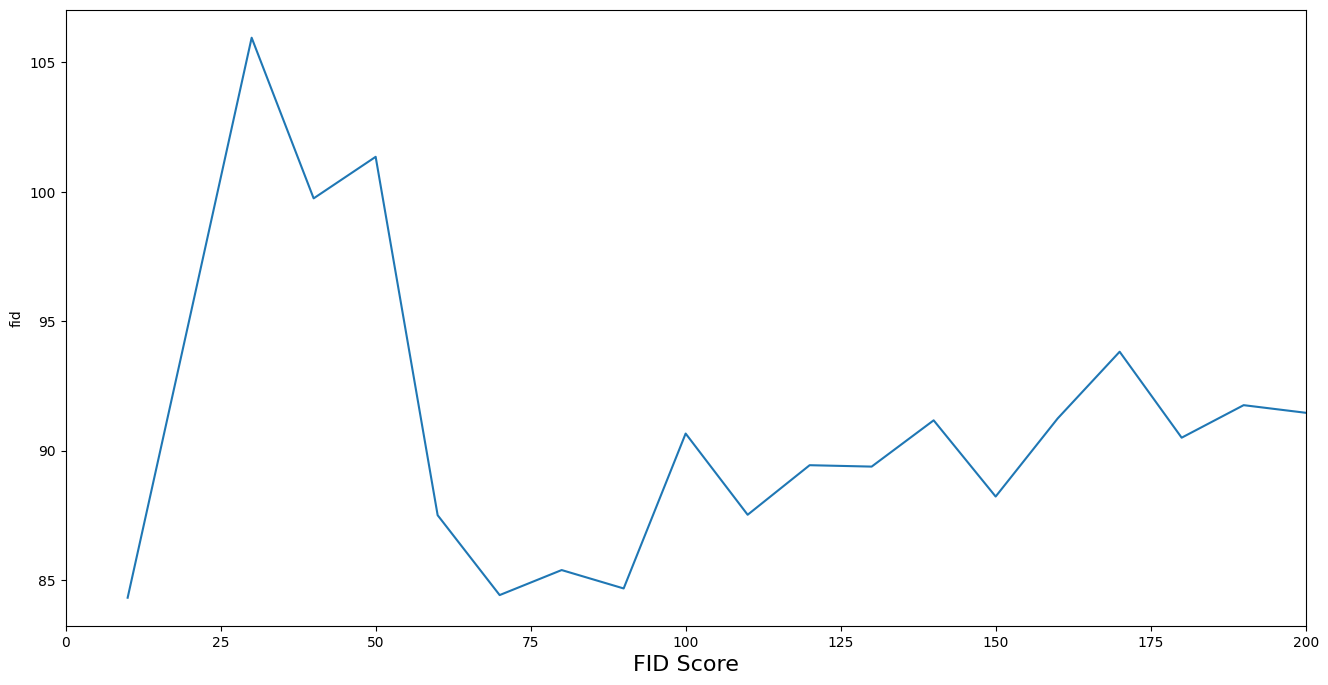

In [5]:
fid_file = '../logs/autopainter/fid_scores.csv'
autopainter_fid = fid.parse_fid(fid_file, plot = True)

In [ ]:
autopainter_fid.sort_values('fid')

In [6]:
merged_fid = autopainter_fid.merge(pix2pix_fid, on = 'epoch', suffixes = ('_autopainter', '_pix2pix'))

In [7]:
merged_fid

,epoch,fid_autopainter,fid_pix2pix
0,200,91.462,86.736
1,190,91.756,89.980
2,180,90.499,91.997
3,170,93.821,91.262
4,160,91.242,88.974
5,150,88.225,88.369
6,140,91.170,87.244
7,130,89.382,88.852
8,120,89.436,89.558
9,110,87.521,85.788


In [8]:
merged_fid.nsmallest(5, 'fid_autopainter')

,epoch,fid_autopainter,fid_pix2pix
19,10,84.315,96.391
13,70,84.417,89.751
11,90,84.673,88.187
12,80,85.384,87.495
14,60,87.503,90.677


In [9]:
merged_fid.nsmallest(5, 'fid_pix2pix')

,epoch,fid_autopainter,fid_pix2pix
9,110,87.521,85.788
10,100,90.659,86.673
0,200,91.462,86.736
6,140,91.170,87.244
12,80,85.384,87.495


In [ ]:
epochs_to_use = [60, 80, 100, 140, 200]

In [ ]:
fig, ax = plt.subplots(figsize = (16, 8))

sns.lineplot(x = merged_fid.epoch, y = merged_fid.fid_pix2pix, label = 'pix2pix', ax = ax);
sns.lineplot(x = merged_fid.epoch, y = merged_fid.fid_autopainter, label = 'Autopainter', ax = ax);

configure_axislabels_and_title('Epochs', 'FID Score', 'Frechet Inception Distance (FID) Across Epochs', ax = ax);
configure_ticklabels_and_params(ax = ax);
configure_legend(ax = ax, fancybox = True, frameon = True, fontsize = 16);

plt.savefig('../visualizations/model_health/FID_scores.png', format = 'png', bbox_inches = 'tight')